In [1]:
%matplotlib inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.grid'] = False

import logging
logger = logging.getLogger()

5 Link Analysis
========

### 5.1 PageRank
#### 5.1.1 Eearly Search Engines and Term Spam
**inverted index**:     
a data structure that makes it easy to find all the palces where that a term given occurs.

**term spam**:    
techniques for fooling search engines.

To combat term spam, Google introduced two innovations:

1. PageRank was used to simulate where Web surfers.  $\gets$ random surfer.

2. Use those links that links to the page.  $\gets$ "vote with their feet."


#### 5.1.2 Definiton of PageRank
intent: the higher the PageRank of a page, the more "important" it is.

**transition matrix**:    
to describe what happens to random surfers after one stop.    
$m_{ij} = \frac{1}{k}$ if page $j$ has $k$ arcs out, and one of them is to page $i$.     
Otherwise, $m_{ij} = 0$.

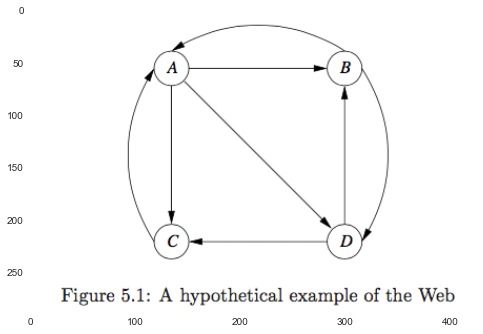

In [2]:
plt.imshow(plt.imread('./res/fig_5_1.png'))

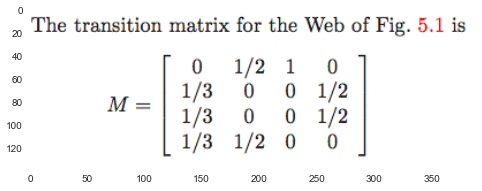

In [3]:
plt.imshow(plt.imread('./res/eg_5_1.png'))

PageRank $v$ simulate random surfers: 

1. start at a random page of all $n$.    
   $v_i^0 = \frac{1}{n} \quad i = 1, 2, \dotsc, n$.
   
2. randomly choose next page linked.     
   $v^{k+1} = M v^{k}$     
   give us the distribution of the surfer after $k+1$ stpes.

In [4]:
# eg. 5.1
matrix_5_1 = np.array([
                [0, 1/3, 1/3, 1/3],
                [1/2, 0, 0, 1/2],
                [1, 0, 0, 0],
                [0, 1/2, 1/2, 0]
             ]).T

matrix_5_1

array([[ 0.        ,  0.5       ,  1.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [5]:
n = matrix_5_1.shape[1]

v = np.ones((n,1)) / n
v

array([[ 0.25],
       [ 0.25],
       [ 0.25],
       [ 0.25]])

In [6]:
def dist_after_surfing(M, v=None, steps=1):
    if v is None:
        n = M.shape[1]
        v = np.ones((n,1)) / n
        
    for __ in xrange(steps):
        v = M.dot(v)
        
    return v

steps = 1
v_ = dist_after_surfing(matrix_5_1, v, steps)
v_

array([[ 0.375     ],
       [ 0.20833333],
       [ 0.20833333],
       [ 0.20833333]])

**Markov processes**:     
It is known that the distribution of the surfer approaches a limiting distribution $v$ that satisfies $v = Mv$, provided two conditions are met: 

1. The graph is trongly connnected.     
   namely, it is possible to get from any node to any other node.
   
2. There are no dead ends.

eigenvalue and eigenvector: $Mx = \lambda x$    
$v = x : \lambda = 1 \text{ and } \sum_j x_{ij} = 1 \text{ for every } i$.

$v$ is a [stochastic vector](http://www.math.harvard.edu/~knill/teaching/math19b_2011/handouts/lecture33.pdf), and $M$ is a [stochastic/Markov matrix](https://en.wikipedia.org/wiki/Stochastic_matrix).

**Iteration** $O(M^2)$ is better than **Gaussian elimination** $O(M^3)$.

in practice, for the Web itself, 50-75 itreations are sufficient to converge to within the error limits of double-precision arithmetic.

In [7]:
# eg 5.2
v_ = dist_after_surfing(matrix_5_1, v, 10)
v_

array([[ 0.33325195],
       [ 0.22224935],
       [ 0.22224935],
       [ 0.22224935]])

In [8]:
v_ = dist_after_surfing(matrix_5_1, v, 50)
v_

array([[ 0.33333333],
       [ 0.22222222],
       [ 0.22222222],
       [ 0.22222222]])

In [9]:
v_ = dist_after_surfing(matrix_5_1, v, 75)
v_

array([[ 0.33333333],
       [ 0.22222222],
       [ 0.22222222],
       [ 0.22222222]])

#### 5.1.3 Structure of the Web
Some structures in reality violate the assumptions needed for the Markov-process iteration to converge to a limit.

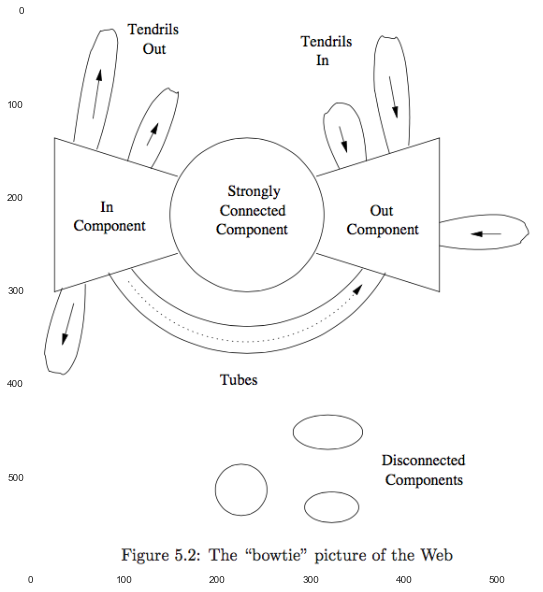

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(plt.imread('./res/fig_5_2.png'))

**Two problems** we need to avoid by modifing PageRank:

1. the dead end.

2. spider traps.     
   the groups of pages that all have outlinks but they never link to any other pages.

#### 5.1.4 Avoiding Dead Ends
Dead Ends $\to$ $M$ is no longer stochastic, since some of the columns will sum to 0 rather than 1.

If we compute $M^iv$ and $M$ is substochastic, then some or all of the components of the vector go to 0.

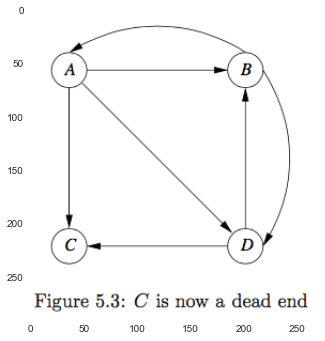

In [11]:
# eg 5.3
plt.imshow(plt.imread('./res/fig_5_3.png'))

In [12]:
M = np.array([
        [0, 1/3, 1/3, 1/3],
        [1/2, 0, 0, 1/2],
        [0, 0, 0, 0],
        [0, 1/2, 1/2, 0]
    ]).T

M

array([[ 0.        ,  0.5       ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [13]:
dist_after_surfing(M, v, 50)

array([[  2.55407417e-08],
       [  3.72237693e-08],
       [  3.72237693e-08],
       [  3.72237693e-08]])

##### Two Solutions
###### 1. Drop the dead end      
   recursive deletion of dead ends, and solve the remaining graph $G'$.     
   then we restore $G$ from $G'$, recursivly.     
   $$ e = \sum \frac{v_p}{k_p} $$    
   where $e \in (G - G')$, $p \in G'$ and is the predecessor of $e$, $k$ is the number of successors of $p$ in $G$.

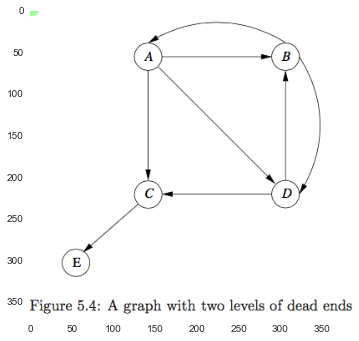

In [14]:
# eg 5.4
plt.imshow(plt.imread('./res/fig_5_4.png'))

In [15]:
M_G = np.array([
        [0, 1/3, 1/3, 1/3, 0],
        [1/2, 0, 0, 1/2, 0],
        [0, 0, 0, 0, 1],
        [0, 1/2, 1/2, 0, 0],
        [0, 0, 0, 0, 0]
    ]).T
M_G

array([[ 0.        ,  0.5       ,  0.        ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [16]:
from sklearn.preprocessing import normalize 

index = [0, 1, 3]
M = M_G.take(index, axis=0).take(index, axis=1)
M = normalize(M, norm='l1', axis=0) 
M

array([[ 0. ,  0.5,  0. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5,  0.5,  0. ]])

In [17]:
n = M.shape[1]
v = np.ones((n,1)) / n

v_ = dist_after_surfing(M, v, 50)
v_

array([[ 0.22222222],
       [ 0.44444444],
       [ 0.33333333]])

In [18]:
# the PageRank of C, whose predecessors are A and D.
1/3 * v_[0] + 1/2 * v_[2]

array([ 0.24074074])

In [19]:
# the PageRank of D, which is the only one successor of C.
# hence, it is the same with C.
_

array([ 0.24074074])

###### 2. modify the process of moving
"taxation"

#### 5.1.5 Spider Traps and Taxation
**spider traps**:     
a set of nodes with no dead ends but no arcs out.      
they cause the PageRank calculation to place all the weights within the spider traps.

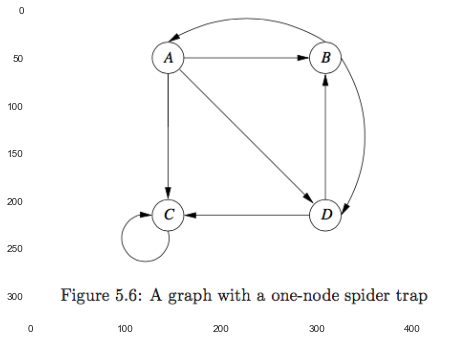

In [20]:
plt.imshow(plt.imread('./res/fig_5_6.png'))

In [21]:
M = np.array([
        [0, 1/3, 1/3, 1/3],
        [1/2, 0, 0, 1/2],
        [0, 0, 1, 0],
        [0, 1/2, 1/2, 0]
    ]).T
M

array([[ 0.        ,  0.5       ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  1.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [22]:
np.round(dist_after_surfing(M, steps=50), 3)

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 0.]])

**Solution**:       
allow each random surfer a small probability of teleporting to a random page.     
$$v = \beta M v + (1 - \beta) \frac{e}{n}$$     
where $n$ is the number of nodes in $G$, and $e$ is a vector of all 1's.

In [23]:
def dist_using_taxation(M, v=None, beta=1, steps=1):
    n = M.shape[1]
    
    if v is None:
        v = np.ones((n,1)) / n
    
    e = np.ones(v.shape) 
    for __ in xrange(steps):
        v = beta * M.dot(v) + (1-beta) * e / n

    return v

dist_using_taxation(M, beta=0.8, steps=30) 

array([[ 0.10135136],
       [ 0.12837839],
       [ 0.64189186],
       [ 0.12837839]])

Although C gets more than half of the PageRank for itself, the effect has been limited.

**Note** that for a random surfer, there are **three path** to move:

1. follow a link.

2. teleport to a random page. $\gets$ taxation

3. goes nowhere. $\gets$ dead ends

Since there will always be some fraction of a surfer operating on the Web, so even if there are dead ends, the sum of the ocmponents of $v$ may be less than 1, but it will never reacher 0.

#### 5.1.6 Using PageRank in a Search Engine
1. find the qualified pages, which have at least one of the search terms in the query.

2. calculate a score for those pages, including PageRank.

#### 5.1.7 Exercises

###### 5.1.1 
略

###### 5.1.2 
略

###### 5.1.3
$n$ nodes: 1/n    
the additional node: n * 1/n * 1/n = 1/n

###### 5.1.4
todo

###### 5.1.5
略

###### 5.1.6
the first node: 1    
the left nodes: 1/2

###### 5.1.7
root: 1    
height = 1:  1/3      
height = 2:  1/3 * 1/2      
height = k:  $\frac{1}{3} \times (\frac{1}{2})^{k-1}, k > 1$

### 5.2 Efficient Computation of PageRank 
PageRank: matrix-vector multiplicaton $\to$ MapReduce.     
However, we must deal with two issues:

1. $M$ is very sparse.     
   list its nonzero elements.

2. we may wish to use a combiner to reduce the amount of data (Map $\to$ Reduce).     
   striping approach.

#### 5.2.1 Representing Transition Matrices
The proper way to represent any sparse matrix is to list the **locations** and **values** of the nonzero entries.    
The space needed is linear in the number of nonzero entries.

Represent a column by:    
    1. one integer for the out-degree,      
    2. one integer for rowname per nonzero entry.

In [24]:
matrix_5_1

array([[ 0.        ,  0.5       ,  1.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [25]:
import string

df_M = pd.DataFrame(matrix_5_1, index=list(string.uppercase[0:4]), columns=list(string.uppercase[0:4]))
df_M

,A,B,C,D
A,0.000000,0.5,1,0.0
B,0.333333,0.0,0,0.5
C,0.333333,0.0,0,0.5
D,0.333333,0.5,0,0.0


In [26]:
def compact_representation_of_sparse_matrix(df):
    """It is introduced in Example 5.7"""
    
    degree = df.apply(np.count_nonzero, axis=0) 
    
    dest = df.apply(np.nonzero, axis=0) 
    dest = dest.apply(lambda x: x[0])
    
    return pd.concat([degree, dest], axis=1, keys=['Degree', 'Destinations']) 
    
    
compact_representation_of_sparse_matrix(df_M)

,Degree,Destinations
A,3,"[1, 2, 3]"
B,2,"[0, 3]"
C,1,[0]
D,2,"[1, 2]"


#### 5.2.2 PageRank Iteration Using MapReduce
estimate: $$v' = \beta M v + (1 - \beta) \frac{e}{n}$$

if $v$ is much too large to fit in main memory, we could use the method of triping:    
break $M $into stripes and break $v$ into corresponding horizontal stripes.

#### 5.2.3 Use of Combiners to Consolidate the Result Vector
There are two reasons the method of Section 5.2.2 might not be adequate:    

1. We might wish to add term for $v'_i$.
    
2. We might execute the iteration step at a single machine or a collection of machines instead.

Hence, we need to implement a combiner in conjunction with a Map task.

**thrashing**:     
repeatly read some components of $v'$.      
An alternative strategy is based on partitioning $M$ into $k^2$ blocks.

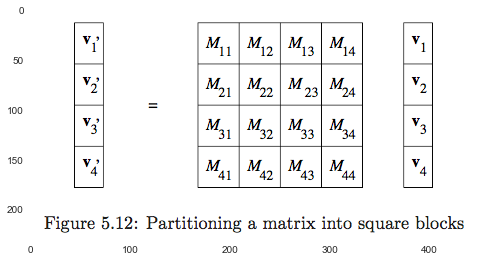

In [27]:
plt.imshow(plt.imread('./res/fig_5_12.png'))

Each task gets $M_{ij}$ and $v_j$.    
Thus, $v$ is transmitted over the network $k$ times, but $M$ is sent only once.

The advantage of this approach is:     
We can keep both the $v_j$ and $v'_i$ in main memory as we process $M_{ij}$.

####  5.2.4 Representing Blocks of the Transition Matrix
for each columns of $M_{ij}$, we need list its out-degree and rows of nonzero entry.     
And it might lead to that the out-degree will be repeated as many times as the out-degree itself.

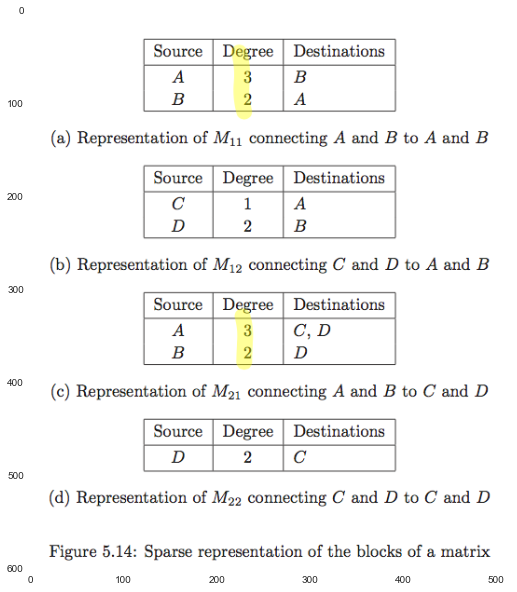

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('./res/fig_5_14.png'))

#todo

#### 5.2.5 Other Efficient Approaches to PageRank Iteration
We can assign all the blocks of one row of blocks to a single Map task,      
namely, use blocks $M_{i1}$ through $M_{ik}$ and all of $v$ to compute $v'i$.

#### 5.2.6 Exercise

###### ex 5.2.1
the fraction of 1's should be less than $\frac{log_2 n}{n}$.

###### ex 5.2.2
略

###### ex 5.2.3
略

###### ex 5.2.4
k = n

### 5.3 Topic-Sensitive PageRank
###### improvement     
we can weight certain pages more heavily because of their topic.

###### motivation    
1. Different people have different interests, and sometimes distinct interests are expressed using the same term in a query.

2. It is not feasible to build a private PageRank vector for each user.

**solution**:     
create one vector for each of some small number of topics, biasing the PageRank to favor pages of that topic,      
and classif users accroding to the degree of their interests in each of the selected topics.      

pons: only store a short vector for each user.      
cons: lose some accuracy.

_note_: One useful topic set is the 16 top-level categories of the Open Directory ([DMOZ](www.dmoz.org)).

#### 5.3.2 Biased Random Walks
**Intuition**:    
Pages linked to by sports pages are themselves likely to be about sports.      

The only difference is how we add the new surfers: 
$$v' = \beta M v + (1 - \beta) \frac{e_s}{|S|}$$
where $S$ is the teleport set (the pages identified as belonging to certain topic), and $e_s$ is a vector that has 1 in the components in $S$ and 0 in other components.

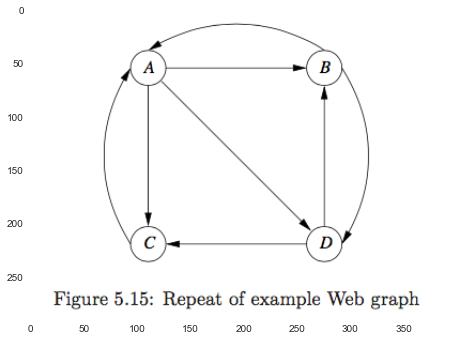

In [29]:
plt.imshow(plt.imread('./res/fig_5_15.png'))

In [30]:
beta = 0.8
M = matrix_5_1
S = ['B', 'D'] 

e_s = pd.Series(np.zeros(4), index=list(string.uppercase[0:4]))
for s in S:
    e_s[s] = 1

e_s

A    0
B    1
C    0
D    1
dtype: float64

In [31]:
M

array([[ 0.        ,  0.5       ,  1.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [32]:
print('v = \n{} v \n+ \n{}'.format(beta*M, (1-beta)*e_s/np.sum(e_s)))

v = 
[[ 0.          0.4         0.8         0.        ]
 [ 0.26666667  0.          0.          0.4       ]
 [ 0.26666667  0.          0.          0.4       ]
 [ 0.26666667  0.4         0.          0.        ]] v 
+ 
A    0.0
B    0.1
C    0.0
D    0.1
dtype: float64


#### 5.3.3 Using Topic-Sensitive PageRank
###### Integrate topic-sensitive PageRank into a search engine
1. Select topics

2. Pick a teleport set for each topic, and compute the topic-sensitive PageRank vector.

3. Find a way of determining the topic of a particular search query.

4. Use the corresponding topic-sensitive PageRank to respond.

###### How to  select topics
+ use the top-level topics of the Open Directory.

+ Allow the user to select a topic from a menu.

+ Infer the topics by the words in search query recently.

+ Infer the topics by information about the user.

#### 5.3.4 Inferring Topics from Words
**Idea**:     
Topics are characterized by words that appear surprisingly often in documents on that topic.

Be **careful**:    
avoid some extremely rare word (eg: misspell) $gets$ put a floor on the number of times a word appears.

It is important to pick reasonably large set $S$ to make sure that we cover all aspects of the topic represented by the set.

We could also blend the topic-sensitive PageRank vectors to reflect user's hybird interests.

### 5.4 Link Spam
**link spam**: the techniques for artificially increasing the PageRank of a page.

**spam farm**: a collection of pages whose purpose is to increase the PageRank of a certain page or pages.

#### 5.4.1 Architecture of a Spam Farm

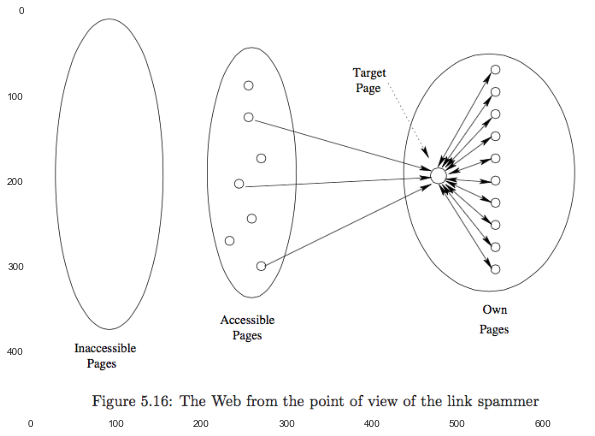

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('./res/fig_5_16.png'))

Links from Accessible Pages: comments contained spam link in blog or news sites.

#### 5.4.2 Analysis of a Spam Farm
Given: $n$ pages in total, $m$ support pages, $y$ is the PageRank of target page $t$.

then:     
the PageRank of each support page:
$$\frac{\beta y}{m} + \frac{1 - \beta}{n}$$

support $x$ is the contribute of all accessible pages for target page.    
we can get the PageRank $p$ of targe page:   

\begin{align}
    p &= x + \beta (\frac{\beta y}{m} + \frac{1 - \beta}{n}) m  + \frac{1 - \beta}{n} \\
      &\approx x + \beta (\frac{\beta y}{m} + \frac{1 - \beta}{n}) m  \\
      &= x + \beta^2 y + \beta (1-\beta) \frac{m}{n}
\end{align}

so we can solve $y$: 
$$y = \frac{x}{1-\beta^2} + c \frac{m}{n}$$ 
where $c = \frac{\beta}{1+\beta}$.

In [34]:
beta = 0.85
x_coe = 1 / (1 - beta**2)
c = beta / (1+beta)

print('y = {} x + {} m/n'.format(x_coe, c))

y = 3.6036036036 x + 0.459459459459 m/n


$\beta = 0.85$ 时，放大 3.6 倍 $x$，同时吸收了 46% 的 $m/n$。

#### 5.4.3 Combating Link Spam
Two Solutions:

1. Identify the structure of spam farm.      
   cons: spammer can modify and develop new spam farm. The war is no end.
   
2. Use infomation (trustyworthy pages) to help judge.      
   + TrustRank    
   + Spam mass
   
##### TrustRank
topic-sensitive PageRank, and the topic is a set of pages believed to be trustworthy (not spam).

**theory**:     
while a spam page might easily be mad to link to a trustworthy page, it is unlikely that a trustworthy page would link to a spam page.

**develop teleport set of trustworthy pages**:    
exclude blog, news sites

+ Let human examine and decide.     
  eg: pick the pages of highest PageRank to examine.
  
+ Pick a domain whose membership is controlled.     
  eg: .edu, .gov, .edu.cn 
  

##### Spam Mass
**idea**: we measure for each page that fraction of its PageRank that comes from spam.

Suppose page $p$ has PageRank $r$ and TrustRank $t$, then the spam mass of $p$ is $$sm(p) = \frac{r-t}{r}$$.

if $sm(p)$ is close to 1, then $p$ is probably spam.    
if $sm(p)$ is negative or small positive, then $p$ might not spam. 

#### 5.4.6 Exercise for Section 5.4
###### 5.4.1
(a)    
targe page $y$: $y = x + \frac{1-\beta}{n}$      
support page $z$: 

\begin{align}
    z &= \beta(\frac{y}{m} + z) + \frac{1-\beta}{n} \\
      &= \frac{\beta}{(1-\beta) m} y + \frac{1}{n}
\end{align}

(b)     
targe page $y$: $y = x + \frac{1-\beta}{n}$      
support page $z$:  $$z = \beta(\frac{y}{m}) + \frac{1-\beta}{n}$$

(c)    
targe page $y$: $$y = x + \beta (\frac{z}{2}) m + \frac{1-\beta}{n}$$      
support page $z$:  $$z = \beta(\frac{y}{m} + \frac{z}{2}) + \frac{1-\beta}{n}$$

then solve $y$ and $z$. 略

###### 5.4.2
略

###### 5.4.3
`#todo`

### 5.5 Hubs and Authorities (HITS, hyperlink-induced topic search)
used by the Ask search eigine.

#### 5.5.1 The Intuition behind HITS
Two flavors of importances:

1. authorities: provide information about a topic.

2. hubs: tell you where to go to find out about that topic.

PageRank: a page is important if important pages link to it.    
HITS: a page is a good hub if it links to good authorities, and a page is a good authority if it is linked to by good hubs.

#### Formalizing Hubbiness and Authority
$h$ - hubbiness vector, $a$ - authority vector.

In case of growing beyond bounds, we normally scale the values of $h$ and $a$: force either its largest component is 1 or the sum of components is 1.

**link matrix**: $L_{ij} = 1$ if page $i$ links page $j$.

We have: $$h = \lambda L a$$
then: $$a = u L^T h$$

By substituting:
\begin{align}
    h &= \lambda u L L^T h \\
    a &= \lambda u L^T L a
\end{align}
Since $L L^T$ and $L^T L$ are not as sparse as $L$ and $L^T$, for web-sized graphs, the only way of computing the solution is **iteratively**:   
1. start with $h$ a vector of all 1's.    
2. Compute $a = L^T h$ and then scale so the largest component is 1.      
3. Next, compute $h = L a$ and scale again.      
4. Repeat step 2-3 until statisfication.

#### 5.5.3 Exercises for Section 5.5
略